# MLP su dati epigenomici 

In [1]:
import nbimporter
from Import_data import get_df_class, get_df_epigenomic, get_df_sequence , get_type_of_nucl_from_list_of_sequence, convertToNum
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

sns.set_style("ticks")
sns.set(color_codes=True)

# RandomForest
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#BO
from GPyOpt.methods import BayesianOptimization
from numpy.random import seed

#https://stackoverflow.com/questions/51480776/how-to-implement-ratio-based-smote-oversampling-while-cv-ing-dataset
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

#path
path_relazione = '../../relazione/img/'
path_output = '../output/'

%matplotlib inline

random_state = 42
seed(random_state)
problem = ['A-E','I-E']
line = 'HepG2'

Importing Jupyter notebook from Import_data.ipynb


Using TensorFlow backend.
/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
cell_line = line
path_c = f'../data/classes/{cell_line}_class.csv'
path_e = f'../data/epigenomic-data/{cell_line}.csv'
path_s = f'../data/sequences/{cell_line}.fa'

df_c = get_df_class(path_c)
df_e = get_df_epigenomic(path_e)
df_s = get_df_sequence(path_s)

problem_slug = "_vs_".join(problem)
problem_slug

'A-E_vs_I-E'

## Zero centering

In [3]:
df_e.head()

ARID3A  ATF3  BHLHE40  BRCA1  C-JUN(JUN)  C-MYC(MYC)  CEBPB  CEBPD  CEBPZ  \
0    3.68  0.40     2.33   1.80        1.45        7.30   1.04   4.21   0.28   
1    5.16  0.82    21.78   3.42        5.69        4.79  42.64   5.44   1.28   
2    4.37  0.40    23.18   5.15        2.59       16.11   6.15   5.56   0.68   
3    2.70  0.85     6.22   1.70        0.13       12.11   0.93   4.01   0.14   
4    1.24  0.73     2.90   1.92        0.49        6.46   1.10   2.96   0.09   

   CHD2  ...  TCF7L2  TEAD4  TR4(NR2C2)  USF1  USF2   YY1  ZBTB33  ZBTB7A  \
0  1.44  ...    0.50   6.50        0.73  1.14  2.54  7.75    1.29    2.34   
1  4.26  ...    0.12   0.73        0.67  1.77  2.81  2.58    0.49    5.29   
2  9.92  ...    1.44   5.46       12.05  2.80  2.62  4.94    1.38    7.76   
3  3.75  ...    0.27   1.06        1.66  1.75  0.91  7.18    0.26    3.89   
4  3.42  ...    0.27   0.90        4.91  1.74  0.90  2.37    0.75    1.86   

   ZEB1  ZNF274  
0  2.70    0.36  
1  2.50    0.13  
2  2.98    0.28  
3  1.47    0.00  
4  2.56    0.14  

[5 rows x 72 columns]

In [4]:
df_e.describe()

ARID3A           ATF3        BHLHE40          BRCA1  \
count  252091.000000  252091.000000  252091.000000  252091.000000   
mean        0.989475       0.818534       1.485908       1.076801   
std         1.112734       0.631552       3.044870       1.129429   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.380000       0.440000       0.420000       0.430000   
50%         0.700000       0.730000       0.850000       0.840000   
75%         1.180000       1.080000       1.530000       1.410000   
max        36.670000      23.770000      94.610000      44.370000   

          C-JUN(JUN)     C-MYC(MYC)          CEBPB          CEBPD  \
count  252091.000000  252091.000000  252091.000000  252091.000000   
mean        0.688162       1.605322       1.226900       1.172225   
std         1.024621       3.101931       3.155738       1.318965   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.200000       0.210000       0.270000       0.340000   
50%         0.490000       0.680000       0.630000       0.850000   
75%         0.910000       1.650000       1.200000       1.570000   
max        58.600000      91.400000     118.890000      27.650000   

               CEBPZ           CHD2  ...         TCF7L2          TEAD4  \
count  252091.000000  252091.000000  ...  252091.000000  252091.000000   
mean        0.627805       1.447202  ...       0.596550       0.781522   
std         0.556192       2.939498  ...       0.541629       0.794184   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.280000       0.420000  ...       0.240000       0.330000   
50%         0.560000       0.850000  ...       0.490000       0.650000   
75%         0.880000       1.560000  ...       0.840000       1.050000   
max        44.130000     117.970000  ...      31.750000      32.190000   

          TR4(NR2C2)           USF1           USF2            YY1  \
count  252091.000000  252091.000000  252091.000000  252091.000000   
mean        1.044239       0.971033       1.028930       1.535761   
std         2.818333       1.571500       1.735148       3.396809   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.290000       0.380000       0.390000       0.330000   
50%         0.660000       0.730000       0.790000       0.750000   
75%         1.220000       1.130000       1.290000       1.460000   
max       137.920000      63.750000      90.700000      99.480000   

              ZBTB33         ZBTB7A           ZEB1         ZNF274  
count  252091.000000  252091.000000  252091.000000  252091.000000  
mean        0.779693       1.041066       0.971905       0.547231  
std         0.648223       1.059833       0.846429       0.563004  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.470000       0.390000       0.380000       0.100000  
50%         0.700000       0.830000       0.840000       0.410000  
75%         0.980000       1.410000       1.380000       0.810000  
max        23.550000      26.460000      39.450000      19.900000  

[8 rows x 72 columns]

In [5]:
df_e = df_e.subtract(df_e.mean())
df_e.describe()

ARID3A          ATF3       BHLHE40         BRCA1    C-JUN(JUN)  \
count  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05   
mean   5.803512e-14  5.011599e-14 -1.930463e-13  3.909055e-15  9.026723e-14   
std    1.112734e+00  6.315524e-01  3.044870e+00  1.129429e+00  1.024621e+00   
min   -9.894753e-01 -8.185344e-01 -1.485908e+00 -1.076801e+00 -6.881617e-01   
25%   -6.094753e-01 -3.785344e-01 -1.065908e+00 -6.468014e-01 -4.881617e-01   
50%   -2.894753e-01 -8.853442e-02 -6.359076e-01 -2.368014e-01 -1.981617e-01   
75%    1.905247e-01  2.614656e-01  4.409237e-02  3.331986e-01  2.218383e-01   
max    3.568052e+01  2.295147e+01  9.312409e+01  4.329320e+01  5.791184e+01   

         C-MYC(MYC)         CEBPB         CEBPD         CEBPZ          CHD2  \
count  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05   
mean   2.067271e-13 -9.887906e-14 -7.536701e-15 -1.037243e-15  1.544140e-15   
std    3.101931e+00  3.155738e+00  1.318965e+00  5.561917e-01  2.939498e+00   
min   -1.605322e+00 -1.226900e+00 -1.172225e+00 -6.278048e-01 -1.447202e+00   
25%   -1.395322e+00 -9.569000e-01 -8.322255e-01 -3.478048e-01 -1.027202e+00   
50%   -9.253215e-01 -5.969000e-01 -3.222255e-01 -6.780484e-02 -5.972020e-01   
75%    4.467847e-02 -2.690001e-02  3.977745e-01  2.521952e-01  1.127980e-01   
max    8.979468e+01  1.176631e+02  2.647777e+01  4.350220e+01  1.165228e+02   

       ...        TCF7L2         TEAD4    TR4(NR2C2)          USF1  \
count  ...  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05   
mean   ... -5.644408e-15 -6.022506e-14 -5.171605e-14  1.063220e-14   
std    ...  5.416289e-01  7.941836e-01  2.818333e+00  1.571500e+00   
min    ... -5.965503e-01 -7.815221e-01 -1.044239e+00 -9.710328e-01   
25%    ... -3.565503e-01 -4.515221e-01 -7.542391e-01 -5.910328e-01   
50%    ... -1.065503e-01 -1.315221e-01 -3.842391e-01 -2.410328e-01   
75%    ...  2.434497e-01  2.684779e-01  1.757609e-01  1.589672e-01   
max    ...  3.115345e+01  3.140848e+01  1.368758e+02  6.277897e+01   

               USF2           YY1        ZBTB33        ZBTB7A          ZEB1  \
count  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05  2.520910e+05   
mean  -2.959661e-14 -2.446091e-15 -2.598881e-14 -1.219870e-13  2.897246e-14   
std    1.735148e+00  3.396809e+00  6.482228e-01  1.059833e+00  8.464292e-01   
min   -1.028930e+00 -1.535761e+00 -7.796932e-01 -1.041066e+00 -9.719050e-01   
25%   -6.389303e-01 -1.205761e+00 -3.096932e-01 -6.510662e-01 -5.919050e-01   
50%   -2.389303e-01 -7.857613e-01 -7.969325e-02 -2.110662e-01 -1.319050e-01   
75%    2.610697e-01 -7.576129e-02  2.003068e-01  3.689338e-01  4.080950e-01   
max    8.967107e+01  9.794424e+01  2.277031e+01  2.541893e+01  3.847810e+01   

             ZNF274  
count  2.520910e+05  
mean  -2.864618e-14  
std    5.630045e-01  
min   -5.472312e-01  
25%   -4.472312e-01  
50%   -1.372312e-01  
75%    2.627688e-01  
max    1.935277e+01  

[8 rows x 72 columns]

In [6]:
# conversione etichette one_hot (si potrebbe fare anche singolo)
type_of_class = sorted(list(df_c['class'].unique()))
lab2int = convertToNum(type_of_class)
classes = np.asarray([  lab2int(el) for el in df_c["class"].values])
print(type_of_class)
classes

['A-E', 'A-P', 'A-X', 'I-E', 'I-P', 'I-X', 'UK']


array([0, 0, 0, ..., 6, 6, 6])

In [7]:
int_labels = [lab2int(el) for el in problem]
int_labels, problem

([0, 3], ['A-E', 'I-E'])

In [8]:
#selezione del problema
X = df_e.values
y = classes
mask = [ el in int_labels for el in classes ]
X,y = X[mask],y[mask]
set(y), len(y)

({0, 3}, 36021)

In [9]:
def _create01mapping(elements):
    d = { k:v for v,k in enumerate(elements)}
    return lambda x : d[x]

label_mapping = _create01mapping(set(y))
y = np.array([ label_mapping(el) for el in y])

# TP è sempre la classe meno numerosa, è il soggetto di interesse
sum(y == 0),len(y==1)
if sum(y==0) < len(y)/2:
    y = 1-y #flipping
y

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
randSampler = SMOTE(random_state=random_state)

def resampler(x,y):
    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    x, y = randSampler.fit_resample(x, y)
    return x,y

## Ricerca intorni di parametri buoni

In [11]:
import keras
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import losses
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

def getBestThreshold(y_test,y_pred_prob):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_prob,pos_label= 1)
    sensitivity = tpr_keras[len(tpr_keras):0:-1] #correctly classified as positive
    specificity = 1 - fpr_keras[len(tpr_keras):0:-1] #correctly classified as negative
    youden_index = sensitivity + specificity -1
    thresholds_keras = thresholds_keras[len(tpr_keras):0:-1]
    max_threshold_y = thresholds_keras[youden_index.argmax()]
    return max_threshold_y


In [12]:
input_shape = X.shape
print(f'input shape {input_shape}')

def generateMlpModel(h1=256,h2=512,h3=64,a1='relu',a2='relu',a3='relu',a4='sigmoid',d1=0.5,d2=0.5):
    model = Sequential()
    model.add(Dense(h1, activation=a1, input_shape=(input_shape[1],)))
    model.add(Dropout(d1))
    model.add(Dense(h2, activation=a2))
    model.add(Dropout(d2))
    model.add(Dense(h3, activation=a3))

    model.add(Dense(1, activation=a4))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

input shape (36021, 72)


In [13]:
n_split = 3

def black_box_function(x):
    h1,h2,h3,d1,d2 = x[0]
    h1,h2,h3,_,_ = [int(el) for el in [h1,h2,h3,d1,d2] ]
    skf = StratifiedKFold(n_splits=n_split,random_state=random_state)

    #conf_matrix = np.zeros([2,2])
    y_pred_label_tot = None
    y_test_tot = None
    
    for nth, other in enumerate(skf.split(X,y)):
        train_index, test_index = other
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_balanced, y_train_balanced = resampler(X_train, y_train)

        model = generateMlpModel(h1=h1,h2=h2,h3=h3,d1=d1,d2=d2)
        model.fit(X_train_balanced, y_train_balanced,
              batch_size=16,
              epochs=8,
              verbose=0,
              validation_data=(X_test, y_test))

        y_train_pred_prob = model.predict(X_train).ravel()

        max_threshold_y = getBestThreshold(y_train,y_train_pred_prob)

        
        y_test_pred_prob = model.predict(X_test).ravel()
        y_pred_label = y_test_pred_prob > max_threshold_y
        
        y_pred_label_tot = np.concatenate((y_pred_label_tot,y_pred_label)) if not (y_pred_label_tot is None) else y_pred_label
        y_test_tot = np.concatenate((y_test_tot,y_test)) if not (y_test_tot is None) else y_test
    return f1_score(y_test_tot,y_pred_label_tot)

In [14]:
batch_size = 2
num_cores = 2
max_time = 60*60
max_iter = 40
init_points = 40

domain = [
    {'name': 'h1', 'type': 'discrete', 'domain':list(range(16, 512,16))},
    {'name': 'h2', 'type': 'discrete', 'domain':list(range(16, 512,16))},
    {'name': 'h3','type': 'discrete', 'domain': list(range(8,128,8)) },
    {'name': 'd1', 'type': 'continuous', 'domain': (0.1,0.9) },
    {'name': 'd2', 'type': 'continuous', 'domain': (0.1,0.9) },
    #{'name' : 'batch_size' , 'type': 'discrete','domain': list(range(4,32,4))},
    #{'name' : 'epochs' , 'type': 'discrete','domain': list(range(5,30,5))}
]

In [15]:
myBopt = BayesianOptimization(f=black_box_function,
                            domain = domain,
                            maximize=True,
                            normalize_Y = False,
                            model_type="GP",
                            acquisition_type = 'EI',
                            acquisition_jitter= 0.01,#"GP_MCMC",
                            #acquisition_type = "EI",#'EI_MCMC',
                            #evaluator_type = 'predictive',   
                            initial_design_numdata = init_points,
                            batch_size = batch_size,
                            num_cores = num_cores)

myBopt.run_optimization(max_iter=max_iter,max_time=max_time, save_models_parameters=False, verbosity=True)

Instructions for updating:
Colocations handled automatically by placer.WARNING:tensorflow:From /home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.WARNING:tensorflow:From /home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions 

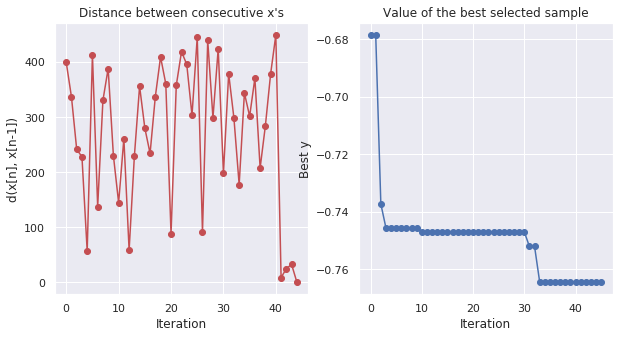

In [16]:
myBopt.plot_convergence(filename=f'{path_output}{cell_line}_{problem_slug}_convergence_mlp_epi.pdf')

In [17]:
from joblib import dump, load
h1,h2,h3,d1,d2 = myBopt.x_opt
np.save(f'{path_output}{cell_line}_{problem_slug}_best_param_mlp_epi', myBopt.x_opt)
#h1,h2,h3,d1,d2 = np.load(f'{path_output}{cell_line}_{problem_slug}_best_param_mpl_epi.npy')
best_model = generateMlpModel(h1=int(h1),h2=int(h2),h3=int(h3),d1=d1,d2=d2)
best_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 352)               25696     
_________________________________________________________________
dropout_1 (Dropout)          (None, 352)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               112960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 112)               35952     
_________________________________________________________________
dense_4 (Dense)      

In [1]:
plot_model(best_model, to_file=path_relazione + f'{cell_line}_{problem_slug}_model_summary_mlp_epi.pdf',show_shapes=True)

NameError: name 'plot_model' is not defined

## Statistiche

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report,precision_recall_curve,average_precision_score,f1_score
from itertools import chain

test_pred_arr = []

skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
for nth, other in enumerate(skf.split(X,y)):
    train_index, test_index = other
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_balanced, y_train_balanced = resampler(X_train, y_train)
    
    best_model.fit(X_train_balanced, y_train_balanced,
              batch_size=16,
              epochs=8,
              verbose=1,
              validation_data=(X_test, y_test))
    
    y_pred_prob = best_model.predict(X_test).ravel()
    
    test_pred_arr.append((y_test,y_pred_prob,nth))

Instructions for updating:
Use tf.cast instead.
Train on 46074 samples, validate on 12008 samples
Epoch 1/8
46074/46074 [==============================] - 12s 261us/step - loss: 0.1267 - acc: 0.9549 - val_loss: 0.1151 - val_acc: 0.9604
Epoch 2/8
46074/46074 [==============================] - 12s 253us/step - loss: 0.0683 - acc: 0.9768 - val_loss: 0.1025 - val_acc: 0.9746
Epoch 3/8
46074/46074 [==============================] - 11s 247us/step - loss: 0.0519 - acc: 0.9829 - val_loss: 0.0984 - val_acc: 0.9799
Epoch 4/8
46074/46074 [==============================] - 12s 257us/step - loss: 0.0437 - acc: 0.9866 - val_loss: 0.1136 - val_acc: 0.9748
Epoch 5/8
46074/46074 [==============================] - 12s 253us/step - loss: 0.0388 - acc: 0.9887 - val_loss: 0.1180 - val_acc: 0.9808
Epoch 6/8
46074/46074 [==============================] - 11s 247us/step - loss: 0.0345 - acc: 0.9896 - val_loss: 0.1132 - val_acc: 0.9813
Epoch 7/8
46074/46074 [==============================] - 11s 248us/step - 

### Raccolta dei risultati

In [2]:
result = {'ROC':{},'PRC':{}}

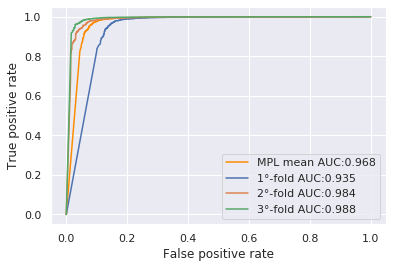

In [21]:
tpr, fpr, threshold = roc_curve(np.concatenate([el[0] for el in test_pred_arr]),1- np.concatenate([el[1] for el in test_pred_arr]))
auc = roc_auc_score(np.concatenate([el[0] for el in test_pred_arr]), np.concatenate([el[1] for el in test_pred_arr]))
plt.figure()
plt.plot(fpr,tpr,color='darkorange', label=f'MLP mean AUC:{auc:.3f}')

for y_t, y_prob_pair, nth in test_pred_arr:
    _tpr,_fpr,_threshold = roc_curve(y_t,1-y_prob_pair)
    _auc = roc_auc_score(y_t, y_prob_pair)
    plt.plot(_fpr,_tpr,label=f'{nth+1}°-fold AUC:{_auc:.3f}')
    
    result["ROC"][nth] = {_auc}

result["ROC"]['tot'] = {auc} 

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='br')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_AUC_ROC_mlp_epi.pdf')
plt.show()

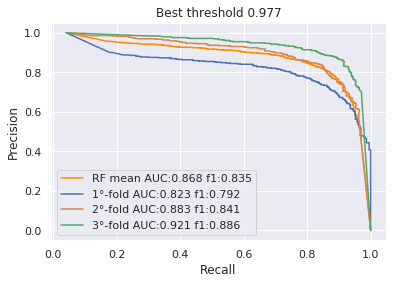

In [22]:
p, r, thr = precision_recall_curve(np.concatenate([el[0] for el in test_pred_arr]), np.concatenate([el[1] for el in test_pred_arr]))
aucprc = average_precision_score(np.concatenate([el[0] for el in test_pred_arr]), np.concatenate([el[1] for el in test_pred_arr]))
f1_score_arr = 2*p*r/(p+r)
index_f1_max = f1_score_arr.argmax()
best_threshold = thr[index_f1_max]
f1 = f1_score(np.concatenate([el[0] for el in test_pred_arr]), np.concatenate([el[1] for el in test_pred_arr])>best_threshold)

plt.figure()

plt.plot(p,r,color='darkorange', label=f'MLP mean AUC:{aucprc:.3f} f1:{f1:.3f}')
    
for y_t, y_prob_pair, nth in test_pred_arr:
    _p,_r,_thr = precision_recall_curve(y_t, y_prob_pair)
    _f1_score_arr = 2*_p*_r/(_p+_r)
    _best_threshold = _thr[_f1_score_arr.argmax()]
    _f1 = f1_score(y_t, y_prob_pair>_best_threshold)
    _aucprc = average_precision_score(y_t,  y_prob_pair)
    plt.plot(_p,_r,label=f'{nth+1}°-fold AUC:{_aucprc:.3f} f1:{_f1:.3f}')

    result["PRC"][nth]= [_aucprc,_f1]

result["PRC"]['tot']= [aucprc,f1]

plt.title(f'Best threshold {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='br')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_AUC_PRC_mlp_epi.pdf')
plt.show()

In [23]:
dump(result, f'{path_output}{cell_line}_{problem_slug}_best_result_mlp_epi.joblib') 
result

{'ROC': {0: {0.9353481249348681},
  1: {0.9837394454493572},
  2: {0.9879434968502616},
  'tot': {0.968226318698402}},
 'PRC': {0: [0.8233931584721994, 0.7920353982300884],
  1: [0.882688347002245, 0.841237113402062],
  2: [0.9206887931327743, 0.8860759493670886],
  'tot': [0.8681895166987152, 0.8352272727272727]}}

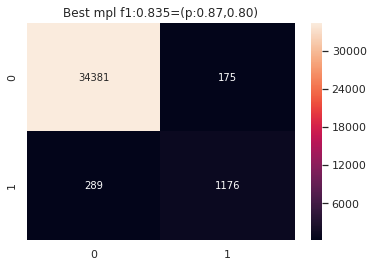

In [24]:
plotted = sns.heatmap(confusion_matrix(np.concatenate([el[0] for el in test_pred_arr]), np.concatenate([el[1] for el in test_pred_arr]) > best_threshold) ,annot=True,fmt="d").set_title(f'Best mpl f1:{f1:.3f}=(p:{p[f1_score_arr.argmax()]:.2f},{r[f1_score_arr.argmax()]:.2f})')
fig = plotted.get_figure()
fig.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_confusion_mlp_epi.pdf')